In [117]:
import numpy as np
import pandahouse
import seaborn as sns
from scipy import stats

In [118]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT distinct user_id
FROM simulator_20220820.feed_actions
WHERE toDate(time) >= '2022-07-13' and toDate(time) <= '2022-07-19'
"""

In [119]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) between '2022-07-03' and '2022-07-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,12681,12681,12681,12681
2,12569,12569,12569,12569


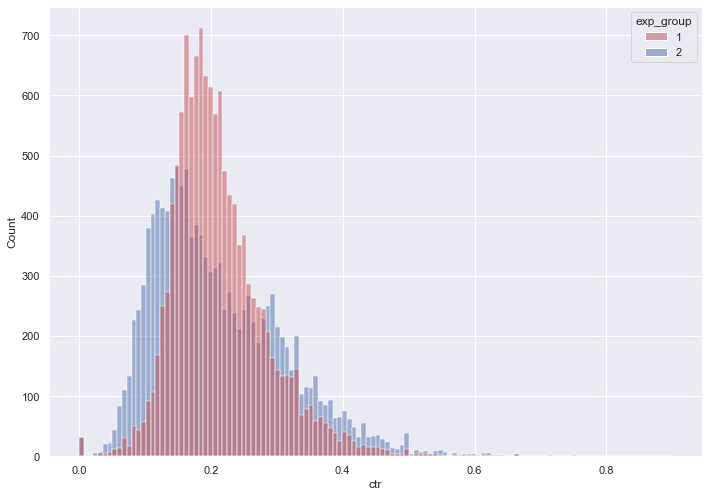

In [120]:
# exp_group = 1 - Все по-старому
# exp_group = 2 - Новые алгоритмы рекомендации постов похожих на лайкнутые
# H0 - группы статистически не отличаются, т.е. новые алгоритмы не оказали влияние на CTR

# Строим изначальное распределение поюзерных CTR в двух группах

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

In [121]:
gr1 = df[df.exp_group == 1]
gr2 = df[df.exp_group == 2]
print(gr1.var()['ctr'])
print(gr2.var()['ctr'])

# дисперсии двух групп неравны, нарушается условие гомогенности дисперсий для теста, поэтому нельзя полагаться на результаты t-test-а

0.00515296778095013
0.010155798314691131


In [122]:
# Выполняем t-test

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

# p-value больше 0.05, согласно этому тесту группы статистически одинаковые

Ttest_indResult(statistic=1.413006673716329, pvalue=0.1576674740938272)

In [123]:
# Выполняем тест Манна-Уитни. Результат - группы статистически разные, p-value около 0

print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                         df[df.exp_group == 2].ctr))

print('Отличие прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]

print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=85959096.0, pvalue=2.81007451537665e-27)
Отличие прокрасилось
В 53.78 % случаев A > B. Должно получиться около 50%


<AxesSubplot:xlabel='ctr'>

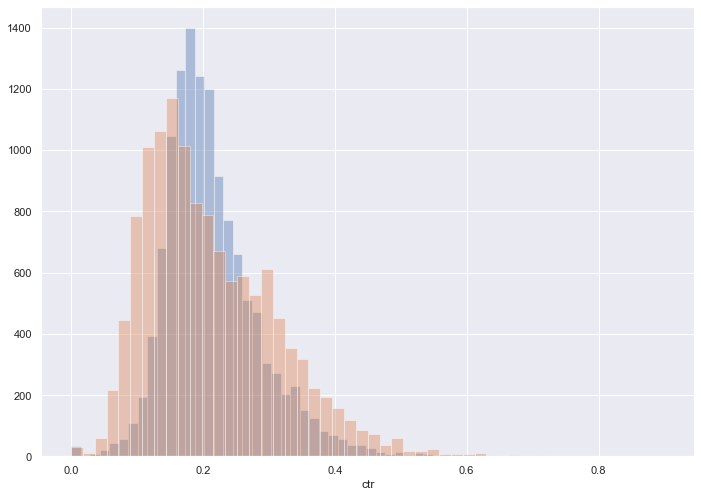

In [124]:
# Сглаженный CTR

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) between '2022-07-03' and '2022-07-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.distplot(group1.ctr,
             kde = False)
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr,
             kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

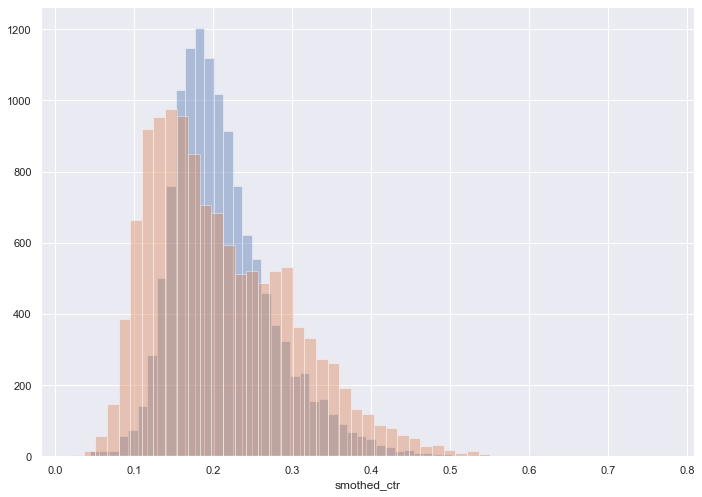

In [125]:
# Применяем функцию сглаживания, строим визуализацию

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr,
             kde = False)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr,
             kde = False)

In [126]:
# Применяем t-test на сглаженные CTR, результат p-value немного превышает 0.05, считаем группы статистически одинаковыми

stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.8929616107113858, pvalue=0.05837572679028761)

In [127]:
# Манна-Уитни показывает p-value <0.05

stats.mannwhitneyu(group1['smothed_ctr'],
                   group2['smothed_ctr'])

MannwhitneyuResult(statistic=86183004.0, pvalue=3.845156313637777e-29)

<AxesSubplot:ylabel='Count'>

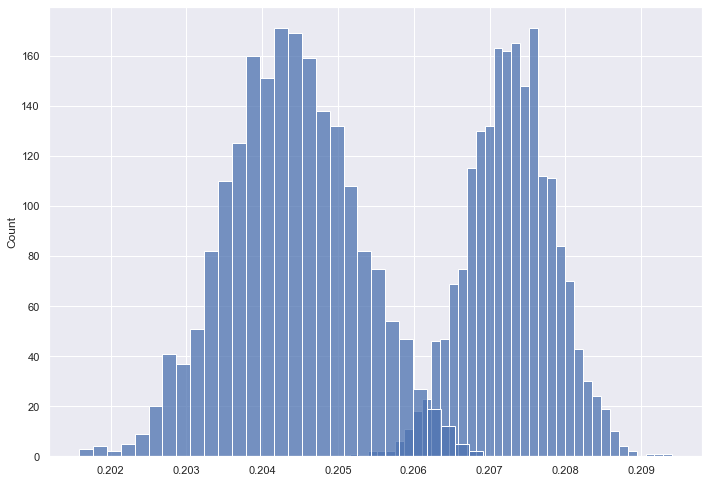

In [128]:
# Бутстреп

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)

    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) between '2022-07-03' and '2022-07-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

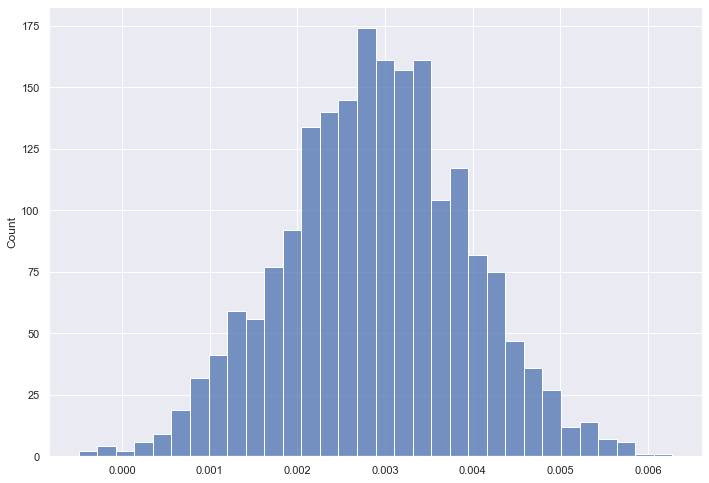

In [129]:
sns.histplot(ctr1 - ctr2)

# Согласно графику распределение разности CTR-ов в двух группах получилось справа от нуля, делаем вывод, что группы статистически разные, при этом в группе 1, где система рекомендаций работает по-старому, CTR выше.

In [130]:
# Бакетное преобразование

q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
        FROM simulator_20220820.feed_actions
        WHERE toDate(time) between '2022-07-03' and '2022-07-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1698.0, pvalue=0.0020356283375791134)

In [131]:
# t-test также видит различие
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                equal_var = False)

Ttest_indResult(statistic=2.6877137322307982, pvalue=0.008681740791411154)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

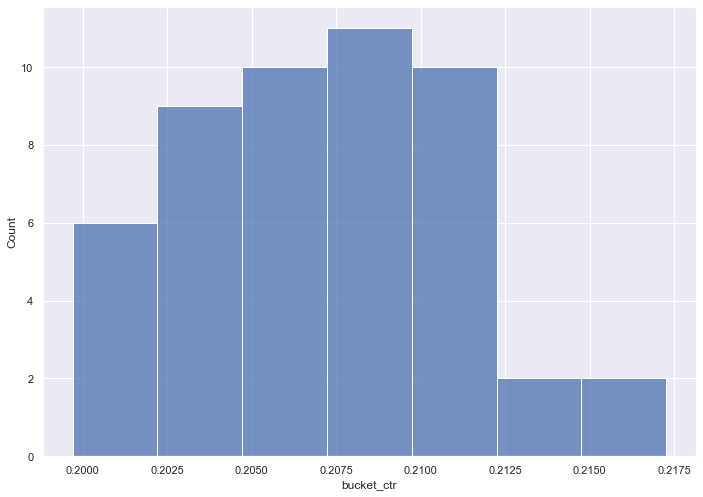

In [132]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

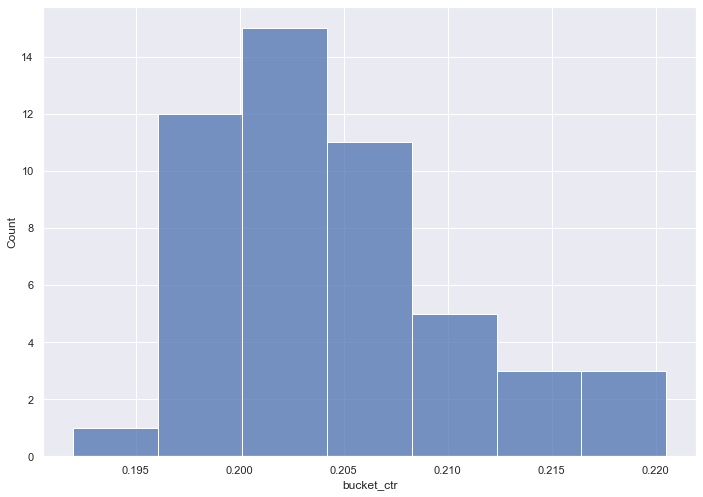

In [133]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

Итог по проведенным тестам:
- t-test: Н0 подтверждена,
- Манна-Уитни: H0 опровегнута,
- сглаженный CTR: Н0 подтверждена t-test-ом, но опровергнута Манной-Уитни,
- бутстреп: H0 опровегнута,
- бакетное преобразование: H0 опровегнута.

Визуально две группы отличаются: форма распределения первой группы более высокая и узкая, чем у второй группы. По форме распределения отличаются от нормального тем, что левый край более крутой, а правый более пологий. Из визуальных отличий делаем предположение, что дисперсии двух групп отличаются, что подтверждено вычислениями перед t-test-ом, а значит для этого теста нарушено условие гомогенности дисперсий выборок, поэтому считаем, что его результаты получились ложными. Средние двух выборок расположены рядом, однако форма их распределения отличается.

Также t-test по сглаженному CTR подтвердил нулевую гипотезу. Для сглаживания был применен гиперпараметр = 5, и визуально распределения CTR после сглаживания поменялись совсем незначительно. Также помним, что неизвестно, будет ли сглаженная метрика сонаправлена несглаженной и делаем предположение, что в данном случае именно поэтому тест показал ложный результат. Манна-Уитни же показал p-value<0.05 (совсем близко к 0).

Остальные тесты можно применять, у нас довольно много сэмплов в каждой выборке, требований к типу распределения нет.

Таким образом считаем, что две группы 1 и 2 статистически отличаются, нагляднее всего это видно на графиках бутсрепа, при этом CTR в 1-й группе в среднем выше, что говорит о том, что система рекомендаций сработала неэффективно, раскатывать на всех пользователей не стоит.

Мы выяснили, что рекомендательная ситема постов, похожих на лайкнутые не сработала как нужно. Возможной причиной того, что рекомендательная система не выстрелила может быть неправильная техническая реализация системы, например, выбраны неверные признаки для определения "похожести" постов, неправильное ранжирование рекомендаций, т.е. пользователю показываются "старые" новостные посты, которые уже не актуальны, или что рекомендации плохо работают для новых пользователей или тех, кто мало лайкает.